# Italian Financial Challenge - Starter Template

**Student Name:** [Your Name]

**Challenge:** [Choose: Bankruptcy Prediction / Financial Health Classification / Revenue Forecasting]

**Date:** [Date]

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:** [Describe which challenge you chose and why]

**Objective:** [State the prediction goal clearly]

**Success Criteria:** [Define what "good" performance looks like for your chosen challenge]

**Approach:** [Briefly outline your planned approach]

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# Create images folder for saved plots
IMAGES_DIR = Path('../images')
IMAGES_DIR.mkdir(exist_ok=True)

def save_fig(name, dpi=150):
    path = IMAGES_DIR / f"{name}.png"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")



Libraries imported successfully!


## 2. Data Loading and Exploration (Refactored EDA: Lean, Defensible, Leakage-Safe)

This section prioritizes a minimal, high-signal set of plots (8–10) with scale-aware visuals.


### 1. Dataset Overview


In [2]:
# Load training data
train_df = pd.read_csv('../data/processed/train_data.csv')

# Explicit target definition for Challenge 3
target_col = 'revenue_change'
target_definition = "Percent change in production_value vs prior year"
target_units = "percentage (%)"

# Columns that are coded as numeric but represent categories
categorical_like_cols = ['ateco_sector'] if 'ateco_sector' in train_df.columns else []

# Basic dataset info
print(f"Dataset shape (rows, cols): {train_df.shape}")
print(f"Unique companies: {train_df['company_id'].nunique()}")
print(f"Fiscal year range: {train_df['fiscal_year'].min()} - {train_df['fiscal_year'].max()}")
print(f"Target: {target_col} ({target_units}) - {target_definition}")

# Feature type breakdown
id_cols = ['company_id']
time_cols = ['fiscal_year']
leakage_targets = ['bankruptcy_next_year', 'financial_health_class']

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

numeric_features = [
    c for c in numeric_cols
    if c not in id_cols + time_cols + [target_col] + leakage_targets + categorical_like_cols
]

categorical_features = [c for c in categorical_cols if c not in id_cols + leakage_targets]
for c in categorical_like_cols:
    if c not in categorical_features:
        categorical_features.append(c)

print("\nFeature type counts:")
print(f"Identifiers: {id_cols}")
print(f"Time columns: {time_cols}")
print(f"Target column: {target_col}")
print(f"Other target cols to exclude: {leakage_targets}")
print(f"Numeric feature cols: {len(numeric_features)}")
print(f"Categorical feature cols: {len(categorical_features)}")
print(f"Total usable feature cols: {len(numeric_features) + len(categorical_features)}")


Dataset shape (rows, cols): (11828, 30)
Unique companies: 2999
Fiscal year range: 2018 - 2021
Target: revenue_change (percentage (%)) - Percent change in production_value vs prior year

Feature type counts:
Identifiers: ['company_id']
Time columns: ['fiscal_year']
Target column: revenue_change
Other target cols to exclude: ['bankruptcy_next_year', 'financial_health_class']
Numeric feature cols: 21
Categorical feature cols: 4
Total usable feature cols: 25


**What this shows:** dataset scale, feature types, and explicit exclusion of leakage targets.  
**Why it matters for modeling:** establishes which columns are safe and eligible for feature engineering.


**Units and domain assumptions:**
- Monetary columns are annual values in euros.
- Ratio columns are unitless and may be negative when equity/profit is negative.
- `revenue_change` is a percent (%) derived from year-over-year production value.


### 2. Helper Functions (Reusable, Leakage-Safe)


In [3]:
# Helper functions (EDA only)

def get_numeric_features(df, exclude_cols, categorical_like_cols):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in numeric_cols if c not in exclude_cols + categorical_like_cols]


def top_skewed_features(df, numeric_features, k=4):
    skew_vals = df[numeric_features].skew(numeric_only=True).abs().sort_values(ascending=False)
    return skew_vals.head(k).index.tolist()


def clip_bounds(series, lower=0.01, upper=0.99):
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return lo, hi


def top_categories_with_other(df, col, top_n=10):
    vc = df[col].value_counts(dropna=False)
    top = vc.head(top_n).index
    return df[col].where(df[col].isin(top), other='Other')


**What this shows:** standardized helpers for clean, repeatable EDA.  
**Why it matters for modeling:** ensures consistent feature selection and category handling without leakage.


### 3. Target Distribution (Skew-Aware)


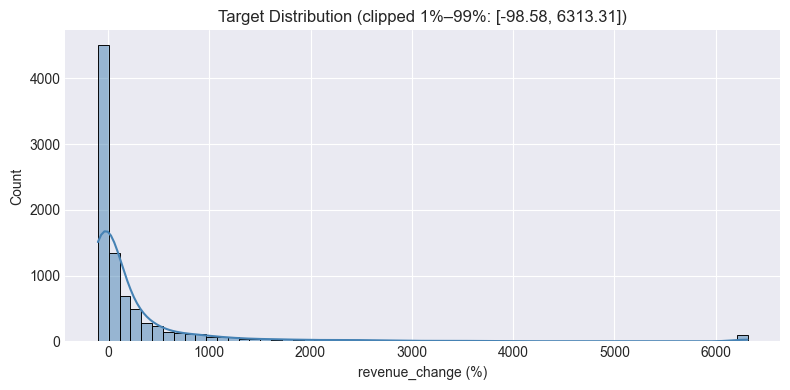

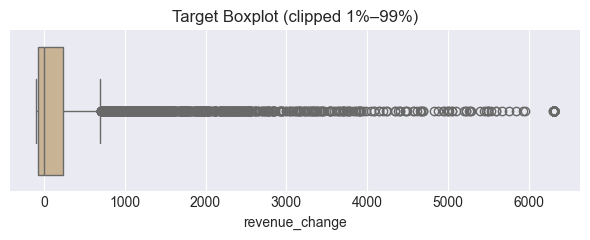

In [4]:
# Target histogram with clipped view (visualization only)
target_series = train_df[target_col].dropna()
lo, hi = clip_bounds(target_series, 0.01, 0.99)

plt.figure(figsize=(8, 4))
sns.histplot(target_series.clip(lo, hi), bins=60, kde=True, color='steelblue')
plt.title(f"Target Distribution (clipped 1%–99%: [{lo:.2f}, {hi:.2f}])")
plt.xlabel(f"{target_col} (%)")
plt.tight_layout()
save_fig('target_hist_clipped')
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=target_series.clip(lo, hi), color='tan')
plt.title('Target Boxplot (clipped 1%–99%)')
plt.tight_layout()
save_fig('target_boxplot_clipped')
plt.show()


**What this shows:** the central mass of the target with heavy tails still present (visual clipping only).
**Why it matters for modeling:** tail risk and heteroskedasticity imply robust losses (MAE/Huber), and possibly log-transforming the target for stability.


### 4. Missingness Overview


Missing Values (non-zero):


,Missing Count,Percentage
revenue_change,2999,25.355090
province,919,7.769699
leverage,45,0.380453
roe,45,0.380453


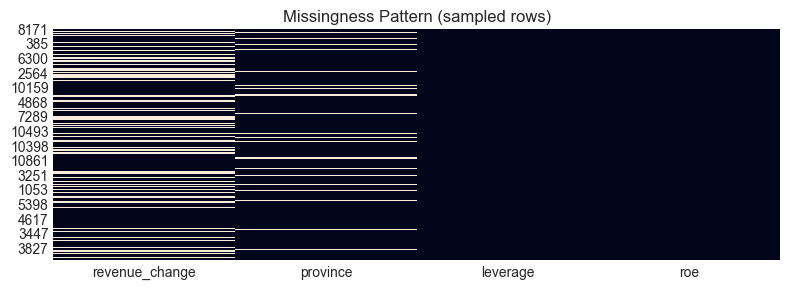

In [5]:
# Missingness table
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Missing Values (non-zero):")
display(missing_df[missing_df['Missing Count'] > 0])

# Missingness pattern heatmap (sampled rows)
missing_cols = missing_df[missing_df['Missing Count'] > 0].index.tolist()
if missing_cols:
    sample = train_df[missing_cols].isna().sample(min(300, len(train_df)), random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 3))
    sns.heatmap(sample, cbar=False)
    plt.title('Missingness Pattern (sampled rows)')
    plt.tight_layout()
    save_fig('missingness_pattern')
    plt.show()


**What this shows:** which columns are incomplete and whether missingness is structured.  
**Why it matters for modeling:** supports targeted imputation and optional missingness indicators.


### 5. Outlier Behavior (Top Skewed Monetary Features)


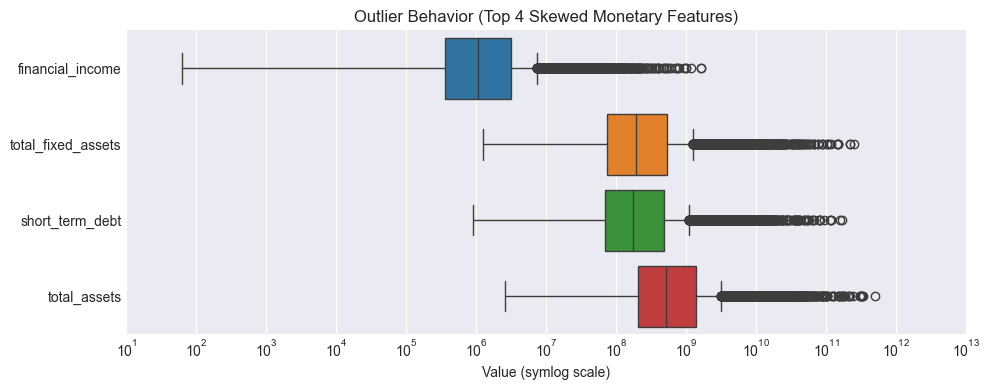

In [6]:
# Outlier behavior via top skewed numeric features (log-scale view for readability)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Heuristic: focus on monetary features (exclude ratios)
monetary_like = [c for c in num_features if any(x in c for x in ['assets', 'debt', 'income', 'value', 'costs', 'profit'])]
if len(monetary_like) >= 4:
    top_outlier_cols = top_skewed_features(train_df, monetary_like, k=4)
else:
    top_outlier_cols = top_skewed_features(train_df, num_features, k=4)

plt.figure(figsize=(10, 4))
sns.boxplot(data=train_df[top_outlier_cols], orient='h')
plt.xscale('symlog', linthresh=1.0)

# Clip x-axis to positive range (no space below 0)
lo, hi = clip_bounds(train_df[top_outlier_cols].stack().dropna(), 0.01, 0.99)
plt.xlim(1e1, 1e13)
plt.title('Outlier Behavior (Top 4 Skewed Monetary Features)')
plt.xlabel('Value (symlog scale)')
plt.tight_layout()
save_fig('outlier_boxplots_top4_symlog')
plt.show()


**What this shows:** tail behavior in core monetary variables without extreme compression.  
**Why it matters for modeling:** motivates robust scaling or tree models that handle heavy tails.


### 6. Representative Numeric Distributions


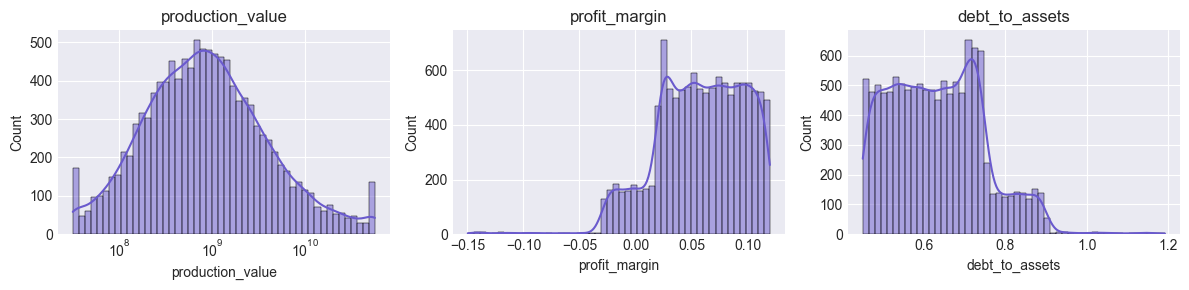

In [7]:
# Representative features: scale (production_value), profitability (profit_margin), leverage (debt_to_assets)
rep_features = [
    c for c in ['production_value', 'profit_margin', 'debt_to_assets']
    if c in train_df.columns
]

fig, axes = plt.subplots(1, len(rep_features), figsize=(4 * len(rep_features), 3))
if len(rep_features) == 1:
    axes = [axes]

for ax, col in zip(axes, rep_features):
    data = train_df[col].dropna()
    if col in ['production_value']:
        data = data.clip(*clip_bounds(data, 0.01, 0.99))
        ax.set_xscale('symlog', linthresh=1.0)
    sns.histplot(data, bins=50, kde=True, ax=ax, color='slateblue')
    ax.set_title(col)

plt.tight_layout()
save_fig('representative_numeric_distributions')
plt.show()


**What this shows:** typical shapes for scale, profitability, and leverage features.  
**Why it matters for modeling:** indicates which variables need scaling or transformation for linear models.


### 7. Multicollinearity Structure


Dropped (scale/total group): ['total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'financial_expenses', 'net_profit_loss']
Kept (scale/total group): ['total_fixed_assets', 'current_assets', 'operating_income', 'financial_income']
Dropped (ratio group): ['quick_ratio']
Kept (ratio group): ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio']


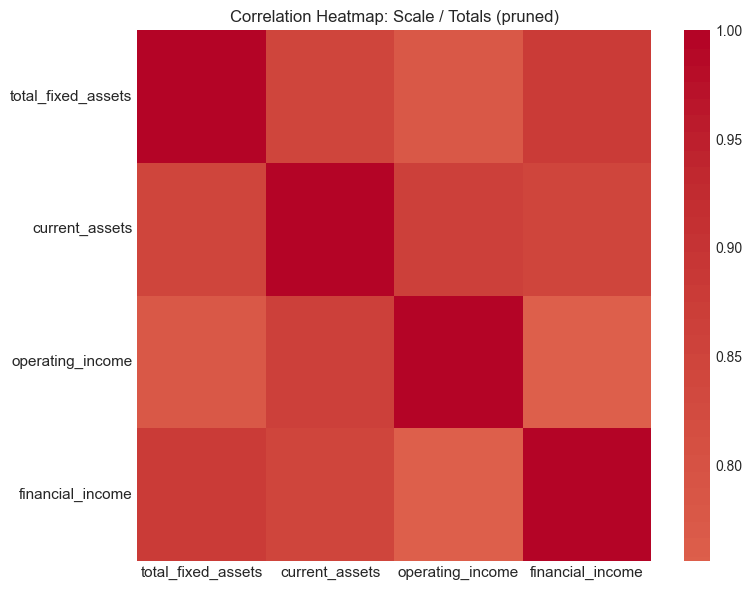

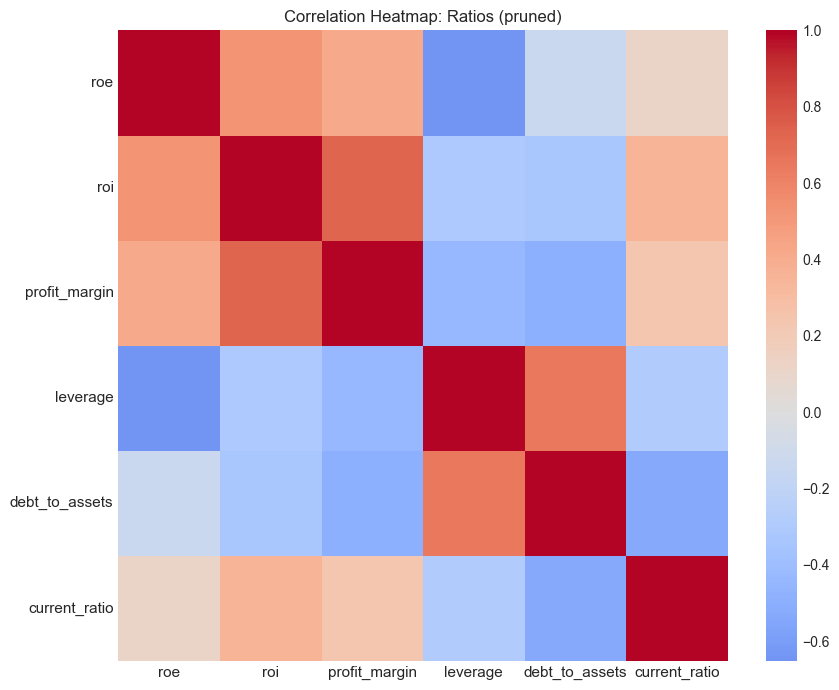

In [26]:
# Correlation heatmaps split into totals vs ratios + drop highly correlated (>|0.90|)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Define ratio vs totals groups (adjust if needed)
ratio_features = [
    c for c in ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio', 'quick_ratio']
    if c in num_features
]

scale_features = [c for c in num_features if c not in ratio_features]

# Drop years_in_business explicitly from scale heatmap
scale_features = [c for c in scale_features if c != 'years_in_business']

# Drop highly correlated features within each group (greedy, |corr| > 0.90)

def drop_high_corr(df, cols, threshold=0.90):
    corr = df[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    keep_cols = [c for c in cols if c not in drop_cols]
    return keep_cols, drop_cols, corr

scale_keep, scale_drop, scale_corr = drop_high_corr(train_df, scale_features, threshold=0.90)
ratio_keep, ratio_drop, ratio_corr = drop_high_corr(train_df, ratio_features, threshold=0.90)

print("Dropped (scale/total group):", scale_drop)
print("Kept (scale/total group):", scale_keep)
print("Dropped (ratio group):", ratio_drop)
print("Kept (ratio group):", ratio_keep)

# Heatmap A: Scale/Totals
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[scale_keep].corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap: Scale / Totals (pruned)')
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
save_fig('correlation_heatmap_scale_totals')
plt.show()

# Heatmap B: Ratios
if len(ratio_keep) > 0:
    plt.figure(figsize=(9, 7))
    sns.heatmap(train_df[ratio_keep].corr(), cmap='coolwarm', center=0, annot=False)
    plt.title('Correlation Heatmap: Ratios (pruned)')
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_ratios')
    plt.show()


**What this shows:** strong linear dependencies among financial totals and ratios.  
**Why it matters for modeling:** suggests regularization (Ridge/ElasticNet) or tree-based models.


### 8. Feature–Target Relationships (Top 2, Interpretable)


Top 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
production_value,0.170943,0.560179
production_costs,0.170918,0.559152
total_assets,0.169760,0.552148
current_assets,0.177701,0.549282
total_debt,0.172818,0.547521
short_term_debt,0.169686,0.544644
long_term_debt,0.170591,0.541096
financial_expenses,0.174653,0.535138
shareholders_equity,0.159066,0.530878
total_fixed_assets,0.147850,0.527453


Bottom 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
financial_income,0.148976,0.458827
net_profit_loss,0.151149,0.432072
roe,0.004309,0.059647
roi,0.010585,0.054975
quick_ratio,-0.008009,-0.012750
current_ratio,-0.008009,-0.012748
years_in_business,0.017032,0.005445
debt_to_assets,-0.002276,-0.000361
profit_margin,0.006333,-0.000231
leverage,-0.005303,-0.000194


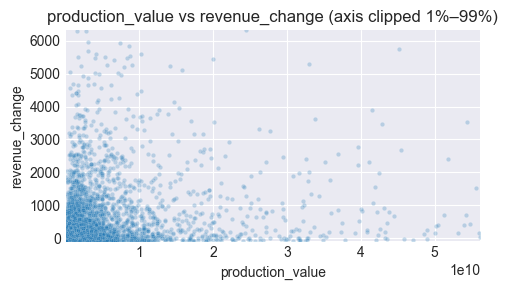

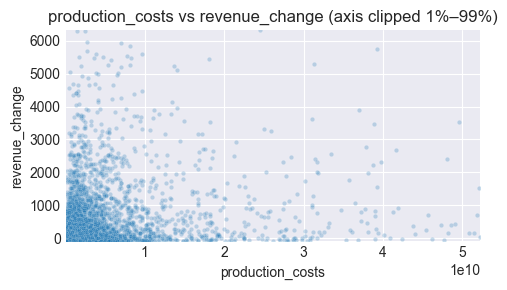

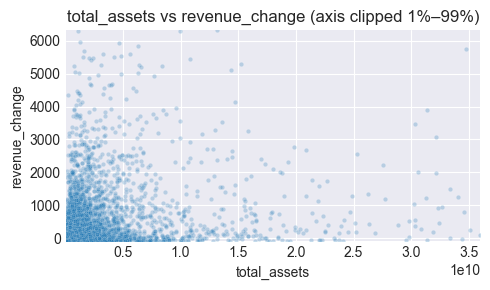

In [9]:
# Correlation of numeric features with target (Pearson and Spearman)
analysis_df = train_df.dropna(subset=[target_col])

numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

pearson_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col])
spearman_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col], method='spearman')

corr_df = pd.DataFrame({
    'pearson': pearson_corr,
    'spearman': spearman_corr
}).sort_values('spearman', key=lambda s: s.abs(), ascending=False)

print("Top 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.head(10))

print("Bottom 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.tail(10))

# Scatter plots for the top 3 features with axis-only clipping (1%–99%)
for col in corr_df.head(3).index:
    x = analysis_df[col].values
    y = analysis_df[target_col].values

    x_clip = clip_bounds(pd.Series(x), 0.01, 0.99)
    y_clip = clip_bounds(pd.Series(y), 0.01, 0.99)

    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=analysis_df, x=col, y=target_col, alpha=0.25, s=10)
    plt.title(f'{col} vs {target_col} (axis clipped 1%–99%)')
    plt.xlim(x_clip)
    plt.ylim(y_clip)
    plt.tight_layout()
    save_fig(f'feature_target_scatter_{col}')
    plt.show()

# Categorical relationships with target (violin plots for top categories) with y-axis clipping
cat_cols = analysis_df.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_cols if c not in ['company_id', 'financial_health_class']]
for c in categorical_like_cols:
    if c not in cat_features:
        cat_features.append(c)



**What this shows:** density concentrates in narrow bands with non‑linear spread and weak conditional shifts.
**Why it matters for modeling:** simple linear fits will underperform; consider log inputs, interaction terms, or tree/boosted models.


### 9. Categorical Signal (Top-N + Other)


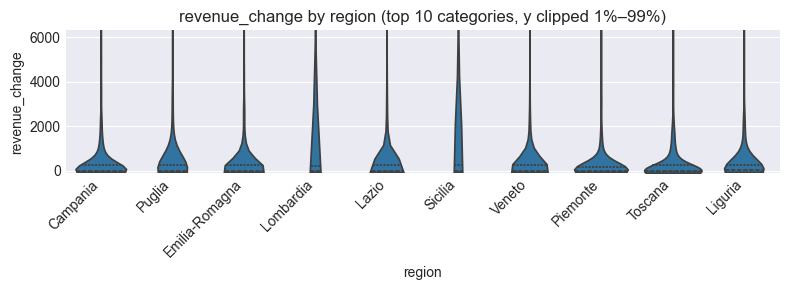

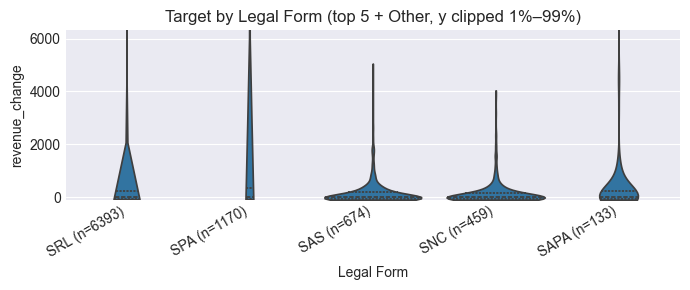

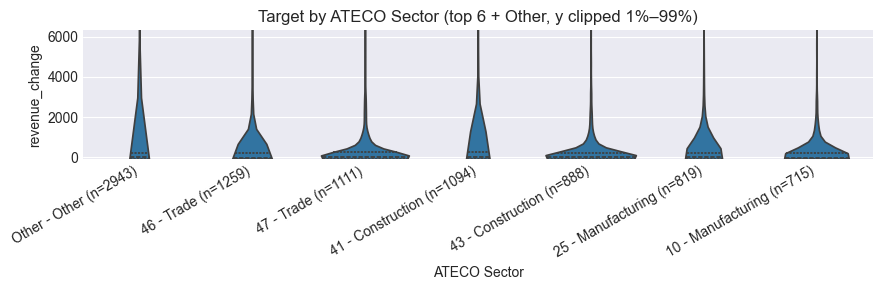

In [10]:
# Compute target clip bounds for consistent y-axis scaling
y_lo, y_hi = clip_bounds(analysis_df[target_col], 0.01, 0.99)

for col in [c for c in [ 'region'] if c in cat_features]:
    top_cats = analysis_df[col].value_counts().head(10).index
    plot_df = analysis_df[analysis_df[col].isin(top_cats)]
    plt.figure(figsize=(8, 3))
    sns.violinplot(data=plot_df, x=col, y=target_col, inner='quartile', cut=0)
    plt.title(f'{target_col} by {col} (top 10 categories, y clipped 1%–99%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig(f'target_by_{col}')
    plt.show()
# Analysis: diagnostics only; do not engineer features here to avoid leakage.

# Target by legal_form (top-N + Other) with y-axis clipping and violin plots
if 'legal_form' in train_df.columns:
    plot_df = train_df[[target_col, 'legal_form']].dropna()
    plot_df['legal_form_grouped'] = top_categories_with_other(plot_df, 'legal_form', top_n=5)

    counts = plot_df['legal_form_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{cat} (n={counts[cat]})" for cat in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(7, 3))
    sns.violinplot(data=plot_df, x='legal_form_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by Legal Form (top 5 + Other, y clipped 1%–99%)')
    plt.xlabel('Legal Form')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_legal_form')
    plt.show()

# Target by ateco_sector (top-N + Other) with y-axis clipping and violin plots
if 'ateco_sector' in train_df.columns:
    plot_df = train_df[[target_col, 'ateco_sector']].dropna()
    plot_df['ateco_sector_grouped'] = top_categories_with_other(plot_df, 'ateco_sector', top_n=6)

    # ATECO 2-digit sector name mapping (compact, for labels)
    def ateco_name(code):
        try:
            c = int(str(code))
        except Exception:
            return 'Other'
        if 1 <= c <= 3:
            return 'Agriculture'
        if 5 <= c <= 9:
            return 'Mining'
        if 10 <= c <= 33:
            return 'Manufacturing'
        if c == 35:
            return 'Utilities'
        if 36 <= c <= 39:
            return 'Water/Waste'
        if 41 <= c <= 43:
            return 'Construction'
        if 45 <= c <= 47:
            return 'Trade'
        if 49 <= c <= 53:
            return 'Transport'
        if 55 <= c <= 56:
            return 'Accommodation/Food'
        if 58 <= c <= 63:
            return 'Info/Comm'
        if 64 <= c <= 66:
            return 'Finance/Insurance'
        if c == 68:
            return 'Real Estate'
        if 69 <= c <= 75:
            return 'Prof/Tech'
        if 77 <= c <= 82:
            return 'Admin/Support'
        if c == 84:
            return 'Public Admin'
        if c == 85:
            return 'Education'
        if 86 <= c <= 88:
            return 'Health/Social'
        if 90 <= c <= 93:
            return 'Arts/Rec'
        if 94 <= c <= 96:
            return 'Other Services'
        return 'Other'

    counts = plot_df['ateco_sector_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{code} - {ateco_name(code)} (n={counts[code]})" for code in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(9, 3))
    sns.violinplot(data=plot_df, x='ateco_sector_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by ATECO Sector (top 6 + Other, y clipped 1%–99%)')
    plt.xlabel('ATECO Sector')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_ateco_sector')
    plt.show()


**What this shows:** category medians differ, but IQR overlap is substantial in several groups.
**Why it matters for modeling:** categories carry signal but require robust encoding; tree models may capture cross‑effects better than linear baselines.


### 10. Leakage Audit (Mandatory)


In [11]:
# Identify suspicious columns that may contain future or post-event info
suspicious_patterns = ['next', 'future', 'after', 't+1', 'post']
flagged_cols = [
    c for c in train_df.columns
    if any(p in c.lower() for p in suspicious_patterns)
]

# Explicit known leakage targets
explicit_leakage = ['bankruptcy_next_year', 'financial_health_class']
flagged = sorted(set(flagged_cols + [c for c in explicit_leakage if c in train_df.columns]))

print("Flagged potential leakage columns:")
print(flagged)

print("\nLeakage prevention steps:")
print("- Exclude flagged columns from feature lists.")
print("- Use temporal splits by fiscal_year to avoid future information.")
print("- Do not engineer features using target values.")
print("- Use transformations only for visualization; no target-conditioned filtering.")


Flagged potential leakage columns:
['bankruptcy_next_year', 'financial_health_class']

Leakage prevention steps:
- Exclude flagged columns from feature lists.
- Use temporal splits by fiscal_year to avoid future information.
- Do not engineer features using target values.
- Use transformations only for visualization; no target-conditioned filtering.


**What this shows:** explicit audit of risky columns and safeguards.  
**Why it matters for modeling:** ensures evaluation integrity and prevents leakage-driven optimism.


### Key EDA Conclusions (Lean Summary)


- Target is heavy‑tailed and skewed; robust losses or transforms are likely necessary.
- Missingness is limited to a few columns, supporting focused imputation.
- Monetary features show extreme outliers; robust scaling or tree models are preferred.
- Strong multicollinearity exists among balance sheet totals; regularization is advisable.
- Legal form and sector show categorical signal worth encoding.
- Leakage risk is controlled by explicit exclusions and temporal splits.


## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

In [12]:
# Create a copy for preprocessing
df_processed = train_df.copy()

# TODO: Handle missing values
# - Decide on imputation strategy (median, mean, by group, etc.)
# - Document your rationale

# TODO: Handle outliers
# - Identify outliers (IQR, winsorization, etc.)
# - Decide on treatment strategy

# TODO: Encode categorical variables
# - One-hot encoding, label encoding, etc.

print("Preprocessing complete!")

Preprocessing complete!


In [13]:
# Train/Validation split
# IMPORTANT: Use temporal split, not random!

# For Challenges 1 & 2:
# train_years = [2018, 2019, 2020]
# val_year = 2021

# For Challenge 3 (time series):
# train_years = [2018, 2019]
# val_year = 2020
# test_year = 2021

# TODO: Implement temporal split
# df_train = df_processed[df_processed['fiscal_year'].isin(train_years)]
# df_val = df_processed[df_processed['fiscal_year'] == val_year]

print("Train/validation split complete!")

Train/validation split complete!


In [14]:
# Feature scaling
# IMPORTANT: Fit scaler on training data only!

from sklearn.preprocessing import StandardScaler, RobustScaler

# TODO: Choose and apply scaler
# scaler = StandardScaler()  # or RobustScaler() for outlier resistance
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

print("Feature scaling complete!")

Feature scaling complete!


## 4. Feature Engineering

Create new features based on domain knowledge.

In [15]:
# TODO: Engineer features
# Ideas:
# - Financial ratios (if not already present)
# - Year-over-year changes (growth rates)
# - Interaction features
# - Altman Z-Score or similar bankruptcy models
# - Sector-relative features (company vs sector average)
# - Temporal features (trends, volatility)

# Example: Year-over-year change
# df_processed = df_processed.sort_values(['company_id', 'fiscal_year'])
# df_processed['roe_yoy_change'] = df_processed.groupby('company_id')['roe'].diff()

print("Feature engineering complete!")
print(f"Total features: {df_processed.shape[1]}")

Feature engineering complete!
Total features: 30


**Engineered Features:**

TODO: List and explain your engineered features
1. 
2. 
3. 

## 5. Model Development

Train multiple models and compare performance.

In [16]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [17]:
# TODO: Prepare X and y
# feature_cols = [...]  # List your feature columns
# target_col = 'bankruptcy_next_year'  # or 'financial_health_class' or 'revenue_change'

# X_train = df_train[feature_cols]
# y_train = df_train[target_col]
# X_val = df_val[feature_cols]
# y_val = df_val[target_col]

print("Data prepared for modeling!")

Data prepared for modeling!


### Baseline Model

In [18]:
# TODO: Train baseline model
# For classification: Logistic Regression
# For regression: Linear Regression

# Example for Challenge 1 (Bankruptcy):
# baseline_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
# baseline_model.fit(X_train_scaled, y_train)
# y_pred_baseline = baseline_model.predict(X_val_scaled)

# print("Baseline Model Performance:")
# print(classification_report(y_val, y_pred_baseline))
# print(f"F1-Score: {f1_score(y_val, y_pred_baseline):.4f}")

### Advanced Models

In [19]:
# TODO: Train multiple models
# - Random Forest
# - XGBoost
# - Gradient Boosting
# - etc.

# For classification with imbalance, consider:
# - SMOTE oversampling
# - Class weights
# - Threshold tuning

# Example for Random Forest with SMOTE:
# smote = SMOTE(random_state=RANDOM_STATE)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=10,
#     random_state=RANDOM_STATE
# )
# rf_model.fit(X_train_resampled, y_train_resampled)

print("Advanced models trained!")

Advanced models trained!


In [20]:
# TODO: Hyperparameter tuning
# Use GridSearchCV or RandomizedSearchCV

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Example:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=RANDOM_STATE),
#     param_grid,
#     cv=StratifiedKFold(n_splits=5),
#     scoring='f1',
#     n_jobs=-1
# )
# grid_search.fit(X_train_scaled, y_train)
# best_model = grid_search.best_estimator_

print("Hyperparameter tuning complete!")

Hyperparameter tuning complete!


## 6. Model Evaluation

Compare models and select the best one.

In [21]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [22]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [23]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
- 
- 

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [24]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [25]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1. 
2. 
3. 

**Revenue Drivers** (for forecasting challenge):
1. 
2. 
3. 

**Actionable Recommendations:**
- 
- 
- 

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
- 
- 

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1. 
2. 
3. 

**Future Improvements:**

TODO: What would you do with more time?
1. 
2. 
3. 

**Lessons Learned:**

TODO: Reflect on the experience
- 
- 

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀